In [9]:
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from alexNet_model_train import AlexNetFineTuner  # Import your AlexNet model class

In [10]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (AlexNet input size)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize with ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [11]:
# Load CIFAR-10 dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use a subset for quick testing (optional)
from torch.utils.data import Subset
# test_dataset = Subset(test_dataset, range(500))  # 100 samples for testing

test_dataloader = DataLoader(test_dataset, batch_size=32)


Files already downloaded and verified


In [12]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define pruning percentages
pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # 0%, 10%, 20%, 30%

In [13]:
def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass through the model
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    all_preds_tensor = torch.tensor(all_preds)
    all_labels_tensor = torch.tensor(all_labels)
    return accuracy(all_preds_tensor, all_labels_tensor, task="multiclass", num_classes=10)

# List to store accuracies for each pruning percentage
accuracies = []

In [14]:
# Loop through each pruning percentage
for amount in pruning_percentages:
    # Reload the model from the checkpoint for each pruning level to start fresh
    checkpoint_path = "../checkpoints/best_checkpoint.ckpt"  # Path to your saved checkpoint
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path)
    model.to(device)
    
    # Apply pruning if amount > 0
    if amount > 0:
        # Prune the weights of convolutional and linear layers
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
                prune.random_unstructured(module, name="weight", amount=amount)
    
    # Evaluate and store accuracy
    test_accuracy = evaluate_model(model, test_dataloader)
    accuracies.append(test_accuracy.item())
    print(f"Test Accuracy after Pruning {amount*100:.0f}% of weights: {test_accuracy:.4f}")


Test Accuracy after Pruning 0% of weights: 0.8891
Test Accuracy after Pruning 10% of weights: 0.6328
Test Accuracy after Pruning 20% of weights: 0.3853
Test Accuracy after Pruning 30% of weights: 0.1822
Test Accuracy after Pruning 40% of weights: 0.1674
Test Accuracy after Pruning 50% of weights: 0.1045


In [15]:
print("Accuracy for random unstructured", accuracies)

Accuracy for random unstructured [0.8891000151634216, 0.6327999830245972, 0.38530001044273376, 0.18219999969005585, 0.16740000247955322, 0.10450000315904617]


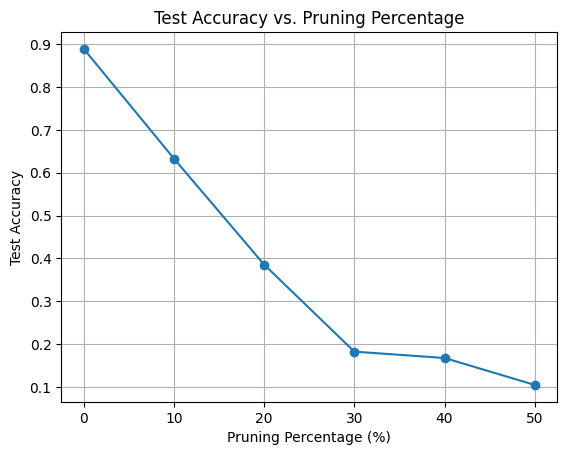

In [16]:
# Plot accuracy vs. pruning percentage
plt.plot([p * 100 for p in pruning_percentages], accuracies, marker='o')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Pruning Percentage')
plt.grid(True)
plt.show()